In [70]:
import pickle
import pandas as pd
import os
from explainers.dce import DistributionalCounterfactualExplainer
import torch
from utils.visualization import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


pd.set_option('display.max_columns', None)

%reload_ext autoreload
%autoreload 2

In [2]:
data_path = 'data/german_credit'

In [3]:
df_ = pd.read_csv(os.path.join(data_path, 'german_credit_data.csv'))
df = df_.copy()
df['Risk'] = df['Risk'].replace({'bad':1, 'good':0})

In [4]:
# Define target column
target_name = 'Risk'
target = df[target_name].replace({"good": 0, "bad": 1})
df[target_name] = target

# Initialize a label encoder and a dictionary to store label mappings
label_encoder = LabelEncoder()
label_mappings = {}

# Convert categorical columns to numerical representations using label encoding
for column in df.columns:
    if column is not target_name and df[column].dtype == "object":
        df[column] = df[column].fillna("Unknown")  # Handle missing values
        df[column] = label_encoder.fit_transform(df[column])
        label_mappings[column] = dict(
            zip(label_encoder.classes_, range(len(label_encoder.classes_)))
        )

# Impute missing values in numerical columns with their median
for column in df.columns:
    if df[column].isna().any():
        median_val = df[column].median()
        df[column].fillna(median_val, inplace=True)


In [6]:
factual = pd.read_csv(os.path.join(data_path,'factual.csv'))
counterfactual = pd.read_csv(os.path.join(data_path,'counterfactual.csv'))

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\leiyo\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmr10.ttf', name='cmr10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\leiyo\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\leiyo\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname

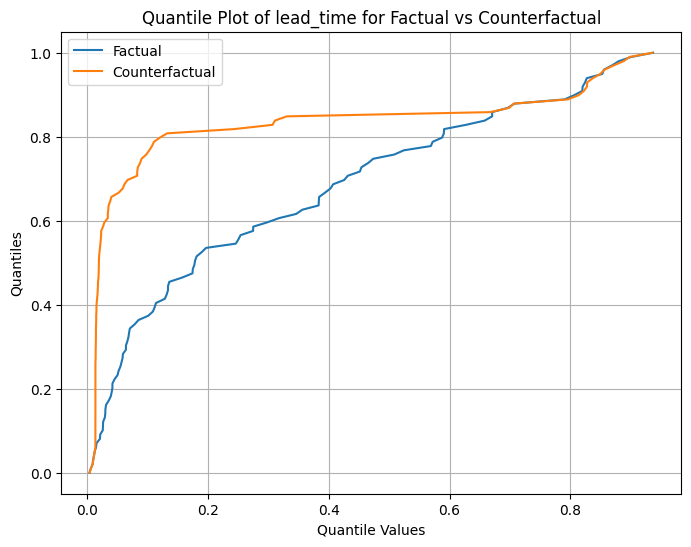

In [7]:
plot_quantile(factual=factual, counterfactual=counterfactual, column_name='Risk');

In [8]:
interval = (0, 25, 35, 65, 120)

cats = ['Student', 'Young', 'Adult', 'Senior']
df["Age_cat"] = pd.cut(df.Age, interval, labels=cats)

for cat in cats:
    risk_prob = df[df.Age_cat == cat]['Risk'].mean()
    print(f'Risk {cat}: {risk_prob}')

Risk Student: 0.42105263157894735
Risk Young: 0.2964824120603015
Risk Adult: 0.24619289340101522
Risk Senior: 0.2777777777777778


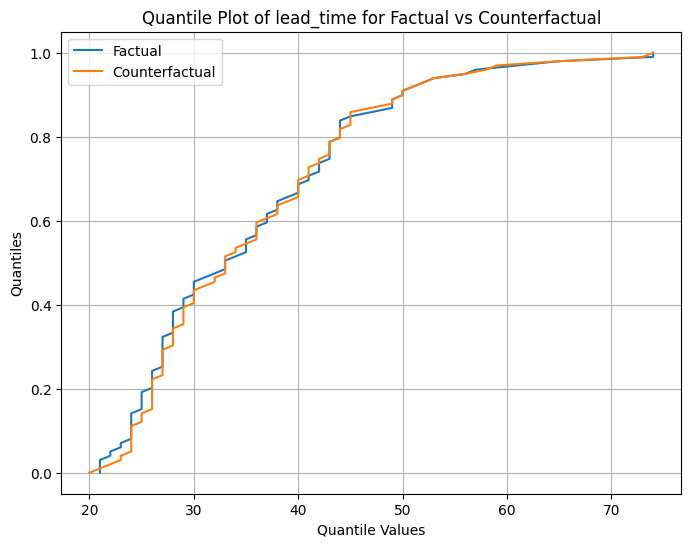

In [9]:
plot_quantile(factual=factual, counterfactual=counterfactual, column_name='Age');

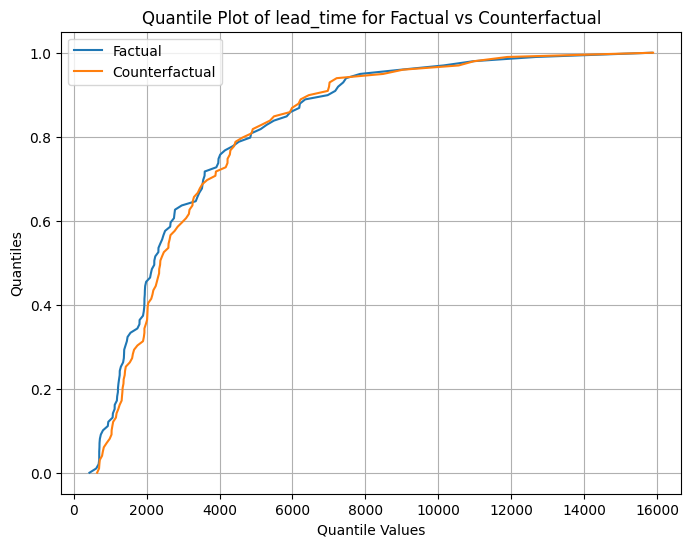

In [10]:
plot_quantile(factual=factual, counterfactual=counterfactual, column_name='Credit amount');

In [11]:
print('Risk Low credit amount:', df[df['Credit amount']<2000]['Risk'].mean())
print('Risk Middle credit amount:', df[ (df['Credit amount']>=2000) & (df['Credit amount']<=6000) ]['Risk'].mean())
print('Risk High credit amount:', df[df['Credit amount']>6000]['Risk'].mean())

Risk Low credit amount: 0.2800925925925926
Risk Middle credit amount: 0.2649164677804296
Risk High credit amount: 0.4563758389261745


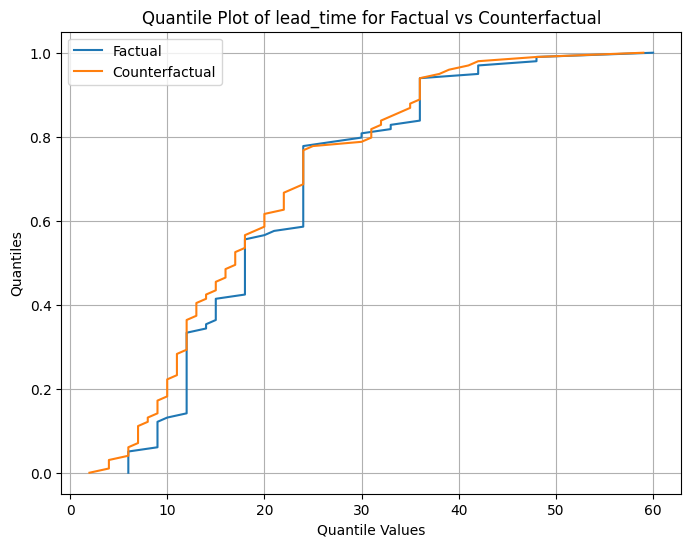

In [18]:
plot_quantile(factual=factual, counterfactual=counterfactual, column_name='Duration');

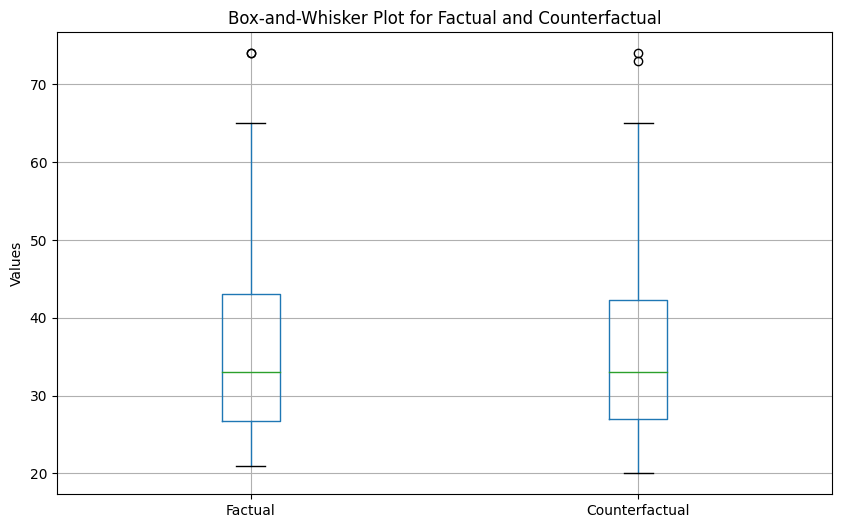

In [12]:
plot_box_whisker(factual=factual, counterfactual=counterfactual, column_name='Age')

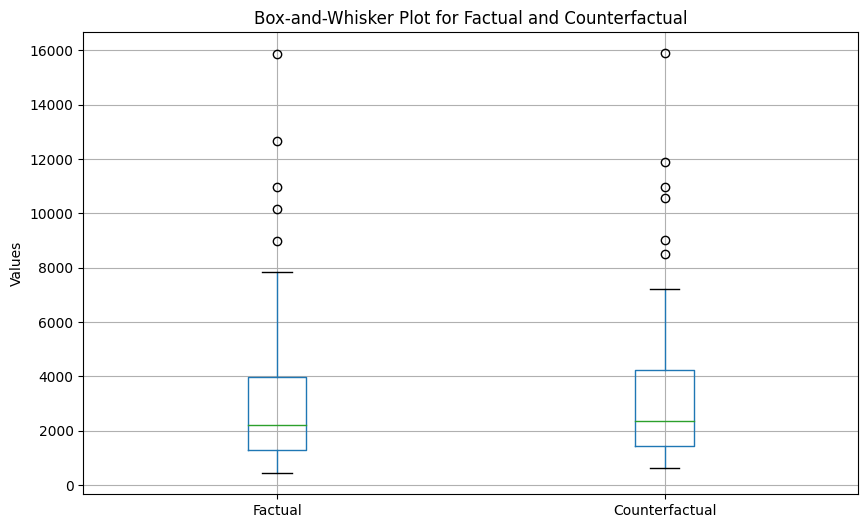

In [13]:
plot_box_whisker(factual=factual, counterfactual=counterfactual, column_name='Credit amount')

In [16]:
factual

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,42,male,2,own,little,little,3446,36,furniture/equipment,0.790291
1,26,male,2,own,little,little,4370,42,radio/TV,0.900538
2,74,female,3,free,little,moderate,5129,9,car,0.696368
3,49,male,1,own,little,Unknown,2096,12,education,0.041956
4,43,female,1,own,little,Unknown,1459,15,radio/TV,0.069521
...,...,...,...,...,...,...,...,...,...,...
95,27,male,2,own,little,little,4020,24,furniture/equipment,0.402759
96,30,male,2,free,quite rich,little,3349,24,furniture/equipment,0.658088
97,21,female,2,rent,Unknown,Unknown,1126,18,radio/TV,0.197014
98,28,female,1,own,little,rich,745,9,radio/TV,0.131707


In [17]:
counterfactual

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,42,male,2,own,little,little,3405,36,furniture/equipment,0.795793
1,26,male,2,own,little,little,4401,42,radio/TV,0.897783
2,74,female,3,free,little,moderate,5150,9,car,0.698479
3,49,male,1,own,little,Unknown,2370,11,education,0.017886
4,43,female,1,own,little,Unknown,2024,13,radio/TV,0.020542
...,...,...,...,...,...,...,...,...,...,...
95,28,male,2,own,little,Unknown,4170,22,furniture/equipment,0.014224
96,28,male,2,free,quite rich,little,3661,22,furniture/equipment,0.330453
97,24,female,2,rent,Unknown,NaN,1336,18,radio/TV,0.013800
98,30,female,1,own,little,rich,800,7,repairs,0.066966


In [19]:
factual['Risk_state'] = factual['Risk'] > 0.5
counterfactual['Risk_state'] = counterfactual['Risk'] > 0.5

factual['Risk_state'] = factual['Risk_state'].replace({True: 'bad', False: 'good'})
counterfactual['Risk_state'] = counterfactual['Risk_state'].replace({True: 'bad', False: 'good'})

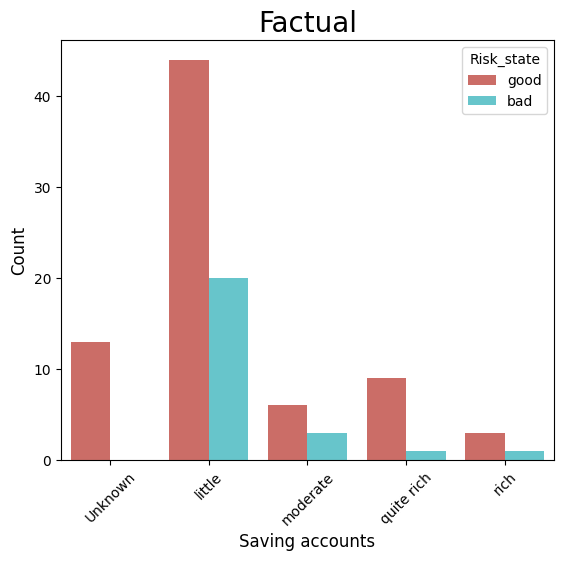

In [77]:
hist_plot(df=factual, x="Saving accounts", hue="Risk_state", title="Factual")

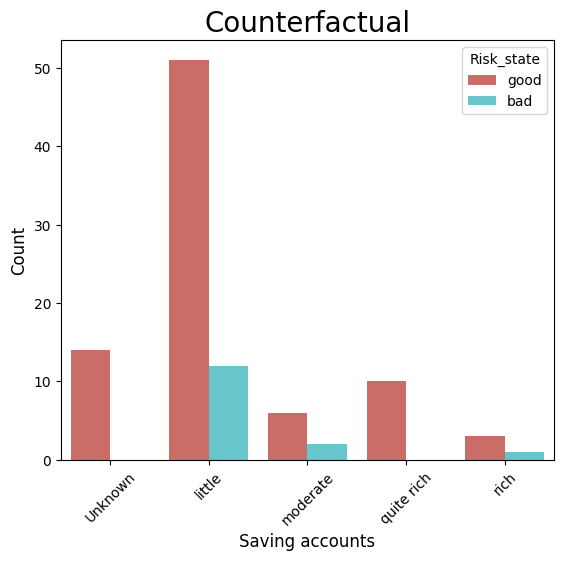

In [78]:
hist_plot(df=counterfactual, x="Saving accounts", hue="Risk_state", title="Counterfactual")

In [82]:
factual_little = factual[factual['Saving accounts'] == 'little']
counterfactual_little = counterfactual[counterfactual['Saving accounts'] == 'little']

In [94]:
factual_little['Risk'].mean(), counterfactual_little['Risk'].mean()

(0.33108168410937505, 0.18851567136507932)

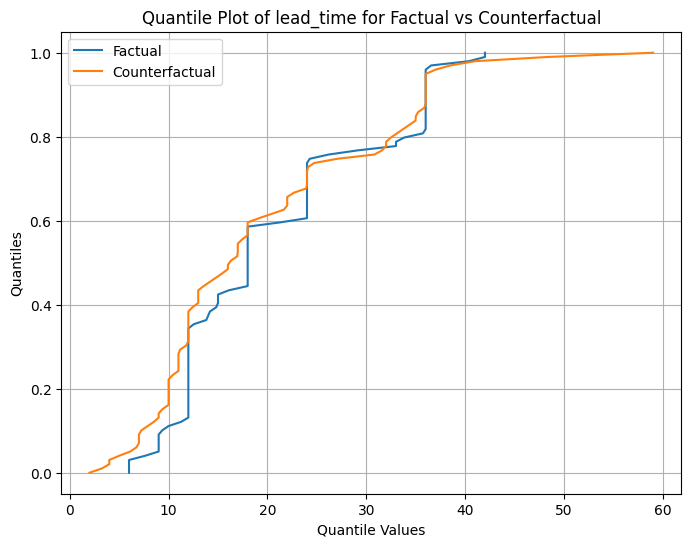

In [88]:
plot_quantile(factual=factual_little, counterfactual=counterfactual_little, column_name='Duration');

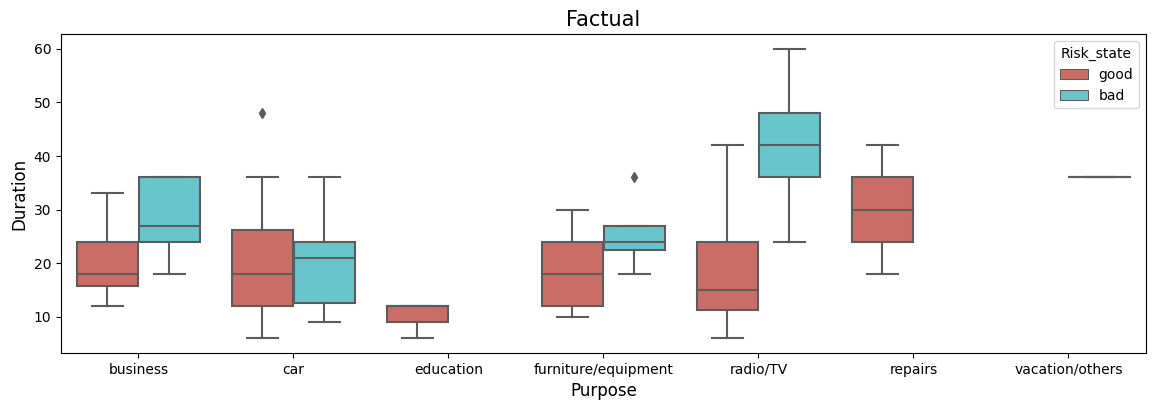

In [95]:
category_box_plot(df=factual_little, x="Purpose", y="Duration", hue="Risk_state", title="Factual")

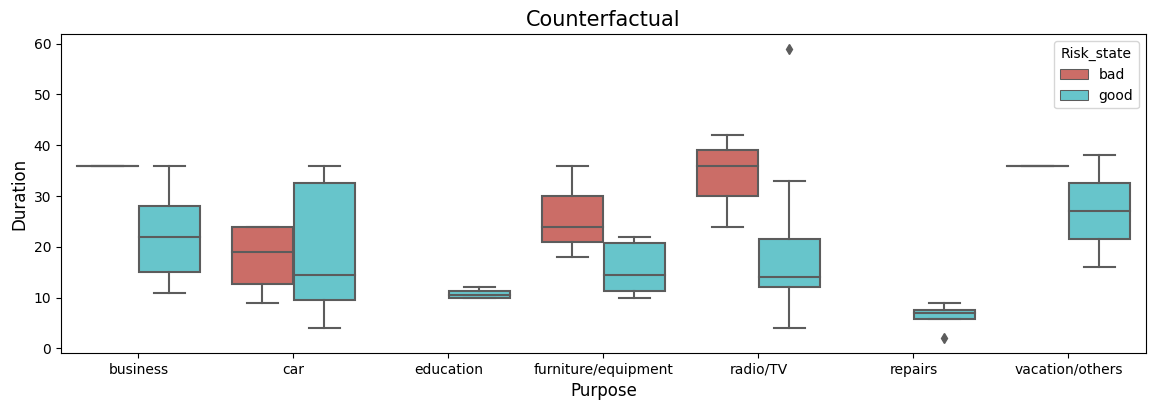

In [116]:
category_box_plot(df=counterfactual_little, x="Purpose", y="Duration", hue="Risk_state", title="Counterfactual")

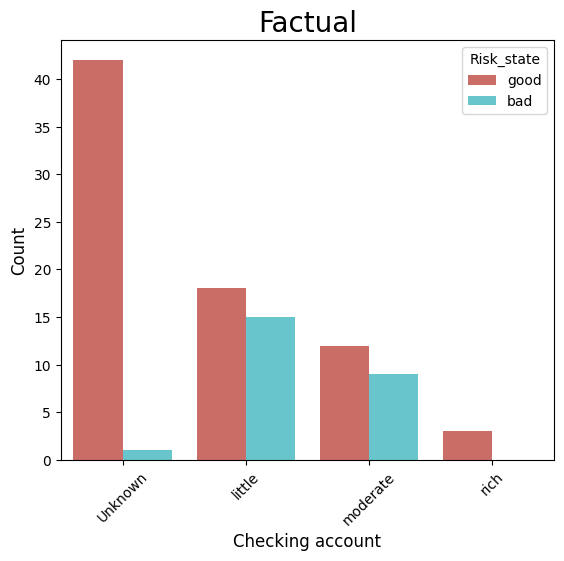

In [113]:
hist_plot(df=factual, x="Checking account", hue="Risk_state", title="Factual")

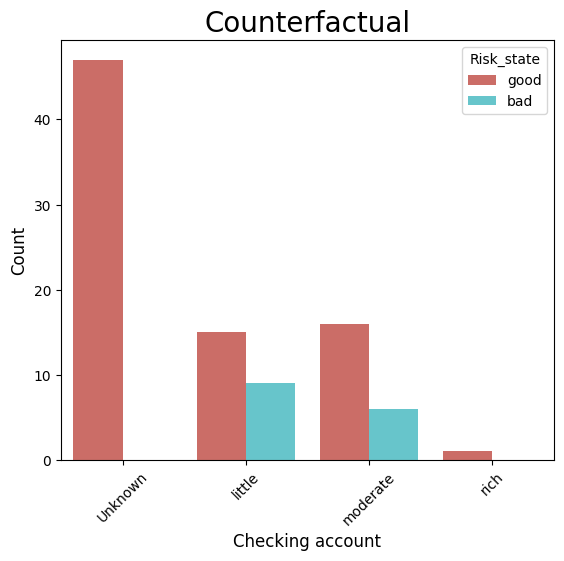

In [117]:
hist_plot(df=counterfactual, x="Checking account", hue="Risk_state", title="Counterfactual")

In [118]:
factual_check_moderate = factual[factual['Checking account']=='moderate']
counterfactual_check_moderate = counterfactual[counterfactual['Checking account']=='moderate']

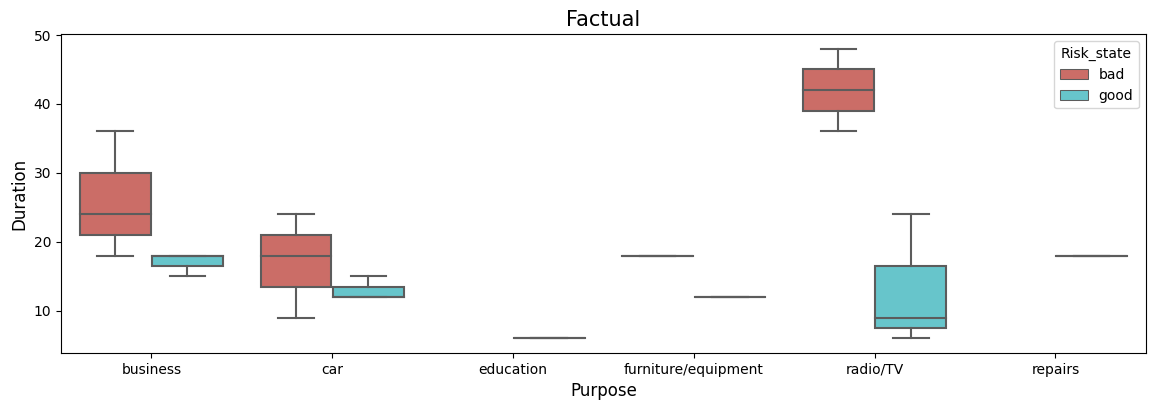

In [121]:
category_box_plot(df=factual_check_moderate, x="Purpose", y="Duration", hue="Risk_state", title="Factual")

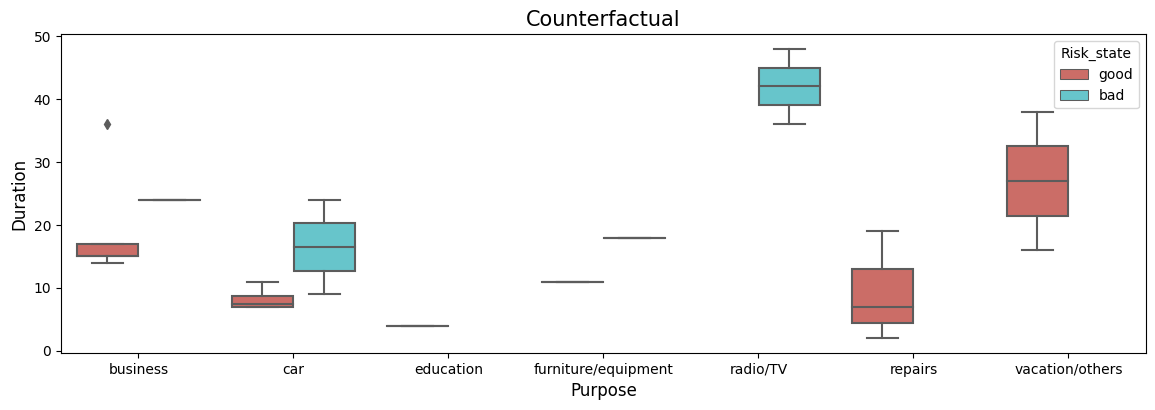

In [122]:
category_box_plot(df=counterfactual_check_moderate, x="Purpose", y="Duration", hue="Risk_state", title="Counterfactual")

In [65]:
factual['Risk'].mean()

0.29830864326699996

In [66]:
counterfactual['Risk'].mean()

0.15987160244300003

In [67]:
with open(os.path.join(data_path, 'explainer.pkl'), 'rb') as file:
    explainer = pickle.load(file)

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x00000244BE83FD30>


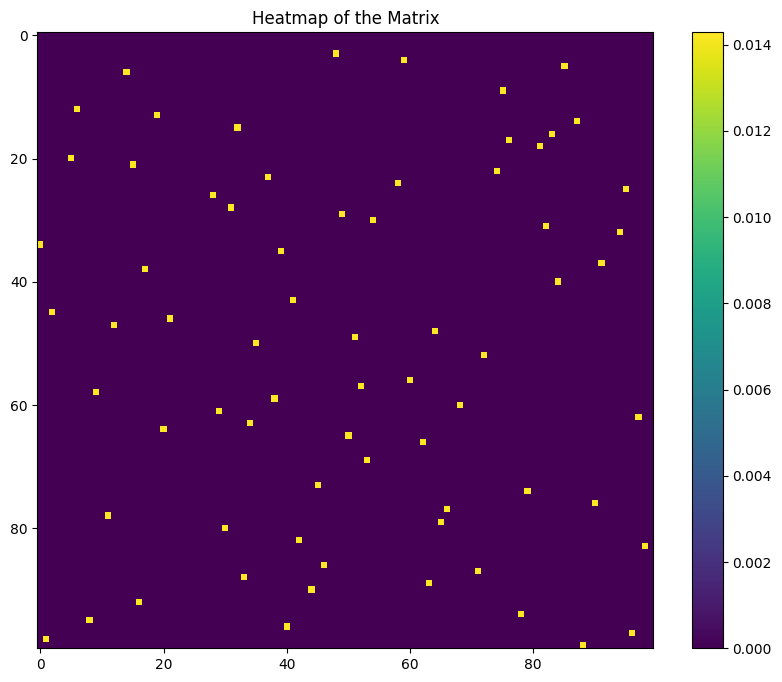

In [68]:
# Sample matrix for demonstration
matrix = explainer.wd.nu.detach().numpy()

plt.figure(figsize=(10, 8))
plt.imshow(matrix, cmap='viridis')
plt.colorbar()
plt.title("Heatmap of the Matrix")
plt.show()


In [108]:
col_names = []
col_scores = []
for column, col_index in zip(explainer.explain_columns, explainer.explain_indices):

    y_s = torch.FloatTensor(explainer.X[:, col_index])
    y_t = torch.FloatTensor(explainer.X_prime[:, col_index])
    wd_dist, _ = explainer.wd.distance(y_s, y_t, delta=0)

    col_names.append(column)
    col_scores.append(wd_dist.item())

pd.DataFrame({
    'Feature': col_names,
    'Score': col_scores,
}).sort_values(by='Score', ascending=False)

,Feature,Score
5,Checking account,0.128827
4,Saving accounts,0.051452
7,Duration,0.027773
2,Job,0.025794
3,Housing,0.024260
8,Purpose,0.018530
6,Credit amount,0.007190
0,Age,0.005101
1,Sex,0.004727
